In [1]:
"""
    This algorithm process to the auto-encoding of the images
"""

'\n    This algorithm process to the auto-encoding of the images\n'

# Getting data

In [1]:
from torch.utils.data import DataLoader
from utils.dataset import imageDataset
from utils.preprocessing import get_data
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
X,y = get_data("./data")

# Getting documents embeddings

In [3]:
import fasttext
from utils.downloader import download, extract_gzip

print("Téléchargement")
#download("https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz", "./data/fastext.cc.en.300.bin.gz")

print("Extraction")
#extract_gzip("./data/fastext.cc.en.300.bin.gz", "./data/fastext.cc.en.300.bin", remove_original=True)

print("Chargement du modèle")
fasttext_model = fasttext.load_model("./data/fastext.cc.en.300.bin")

Téléchargement
Extraction
Chargement du modèle


In [4]:
# No more profil please !

X1 = X[1][X[1]["ViewPosition"].isin(["AP", "PA"])].reset_index(drop=True)
uids = X1["uid"].values.tolist()
X0 = imageDataset(dict([(x,y) for x,y in X[0].image_paths.items() if x in uids]))
labels = y[y["uid"].isin(uids)].reset_index(drop=True)

In [5]:
# Splitting train and test
X0 = X[0]
X0_train, X0_test = X0.split(p=0.7, random_seed=42)

train_id = X0_train.image_list
test_id = X0_test.image_list

X1 = X[1]
X1_train = X1.set_index("uid").loc[train_id,:].reset_index()
X1_test = X1.set_index("uid").loc[test_id,:].reset_index()

y_train = y.set_index("uid").loc[train_id,:].reset_index(drop=True)
y_test = y.set_index("uid").loc[test_id,:].reset_index(drop=True)

y_train_finding_embeddings = np.stack(y_train["report_findings"].fillna("").astype("str").apply(lambda x: fasttext_model.get_sentence_vector(x)).values.tolist())
y_train_impression_embeddings = np.stack(y_train["report_impression"].fillna("").astype("str").apply(lambda x: fasttext_model.get_sentence_vector(x)).values.tolist())

In [6]:
from torchvision.transforms import RandomResizedCrop, Resize, Normalize
import torch
import numpy as np

In [7]:
def dataset_collater (x):
    
    size = 500
    resizer = Resize(size)
    randomcrop = RandomResizedCrop(size=(size,size))
    mean = np.array([0.485, 0.456, 0.406]).mean()
    std = np.array([0.229, 0.224, 0.225]).sum()/np.sqrt(3)
    normalizer = Normalize(mean=mean, std=std)
    
    # Applying randomCrop
    images_tensor = []

    for x_ in x:
        image_tensor = torch.tensor(x_, dtype=torch.float32).unsqueeze(dim=0)
        image_tensor = resizer(image_tensor)
        image_tensor = randomcrop(image_tensor)

        images_tensor.append(image_tensor)

    output = torch.stack(images_tensor)
    output = normalizer(output/255.)

    return output

In [168]:
def dataset_collater_nocrop (x):
    
    size = 500
    resizer = Resize((size, size))
    randomcrop = RandomResizedCrop(size=(size,size))
    mean = np.array([0.485, 0.456, 0.406]).mean()
    std = np.array([0.229, 0.224, 0.225]).sum()/np.sqrt(3)
    normalizer = Normalize(mean=mean, std=std)
    
    # Applying randomCrop
    images_tensor = []

    for x_ in x:
        image_tensor = torch.tensor(x_, dtype=torch.float32).unsqueeze(dim=0)
        image_tensor = resizer(image_tensor)

        images_tensor.append(image_tensor)

    output = torch.stack(images_tensor)
    output = normalizer(output/255.)

    return output

In [9]:
import torch
from torch import nn
from torch import optim
from torchvision.models import resnet50

In [89]:
class autoEncoder (nn.Module):

    def __init__ (self):
        super().__init__()

        self.resnet = resnet50(pretrained=True)

        # Layer that duplicate the color layer (b&w to rgb)
        duplicate_color_layers = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(1,1), padding="same")
        duplicate_color_layers.requires_grad_(False)
        duplicate_color_layers.load_state_dict({
            "weight":torch.ones(duplicate_color_layers.weight.shape, dtype=torch.float32),
            "bias":torch.zeros(duplicate_color_layers.bias.shape)
        })

        self.encoder = nn.Sequential(*[
            duplicate_color_layers,
            nn.Sequential(*list(self.resnet.children())[0:-2]).to("cpu"),
            nn.Conv2d(2048, 1024, (1,1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1, (1,1))
        ])

        self.decoder = nn.Sequential(*[
            nn.Conv2d(1, 16, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample((48,48)),
            nn.Conv2d(16, 32, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample((100,100)),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample((250,250)),
            nn.Conv2d(64, 32, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample((500,500)),
            nn.Conv2d(32, 16, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=(1,1), padding="same"),
        ])

        self.embeddings_decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU()
        )

        self.embeddings_findings = nn.Sequential(
            nn.Linear(512, 300),
            nn.Tanh()
        )


        self.embeddings_impressions = nn.Sequential(
            nn.Linear(512, 300),
            nn.Tanh()
        )

        self.loss = nn.MSELoss()
        self.loss_embeddings = nn.MSELoss()
        self.optim = optim.Adam(self.parameters(), lr=1e-4)

    def forward (self, x):
        y_encode = self.encoder(x)

        return y_encode

    def fullpass (self, x):

        y_encode = self(x)

        y_decode = self.decoder(y_encode)
        y_embeddings = self.embeddings_decoder(y_encode)
        y_findings = self.embeddings_findings(y_embeddings)
        y_impressions = self.embeddings_impressions(y_embeddings)

        return y_decode, y_findings, y_impressions

    def fit (self, x, y):

        self.train()
        self.optim.zero_grad()
        y_findings, y_impressions = y

        x_, y_findings_, y_impressions_ = self.fullpass(x)

        loss_reconstruction = self.loss(x_, x)
        loss_embeddings_findings, loss_embeddings_impressions = self.loss_embeddings(y_findings_, y_findings), self.loss_embeddings(y_impressions_, y_impressions)

        loss = loss_reconstruction + loss_embeddings_findings + loss_embeddings_impressions

        loss.backward()
        self.optim.step()
        
        loss, loss_reconstruction, loss_embeddings_findings, loss_embeddings_impressions = [x.detach().cpu().item()
            for x in [loss, loss_reconstruction, loss_embeddings_findings, loss_embeddings_impressions]
        ]

        return loss, loss_reconstruction, loss_embeddings_findings, loss_embeddings_impressions

In [523]:
ae = autoEncoder()
ae = ae.to("cuda:0")
ae.load_state_dict(torch.load("./models/ae.model"))

In [592]:
ae.optim = optim.Adam(ae.parameters(), lr=1e-6)

In [593]:
dataloader = DataLoader(range(len(X0_train)), shuffle=True, batch_size=4, num_workers=2)

In [804]:
losses = {
    "global":[],
    "reconstruction":[],
    "embeddings_findings":[],
    "embeddings_impressions":[]
}

n_epoch = 5
print_pass = 20

for i in range(n_epoch):
    j = 0
    if len(losses["global"]) > 0:
        loss_mean = dict([(key, np.array(value).mean())
            for key, value in losses.items()
        ])
        print(f"Epoch {i}, Losses : {loss_mean}")

        losses = dict([(key, [])
            for key in losses.keys()
        ])
    
    print(f"Epoch {i}")
    for idx in dataloader:
        x = dataset_collater(X0_train[idx])
        y_findings_embeddings = torch.tensor(y_train_finding_embeddings[idx], dtype=torch.float32)
        y_impressions_embedding = torch.tensor(y_train_impression_embeddings[idx], dtype=torch.float32)

        x = x.to("cuda:0")
        y_findings_embeddings = y_findings_embeddings.to("cuda:0")
        y_impressions_embedding = y_impressions_embedding.to("cuda:0")

        loss = ae.fit(x, (y_findings_embeddings, y_impressions_embedding))
        for key, value in zip(losses.keys(), loss):
            losses[key].append(value)

        j += 1

        if (j % print_pass) == 0:
            loss_mean = dict([(key, np.array(value).mean())
                for key, value in losses.items()
            ])

            print(f"Pass {j} - Loss so far : {loss_mean}")

Epoch 0


AttributeError: 'weakref' object has no attribute 'grad_fn'

In [805]:
from matplotlib import pyplot  as plt

In [806]:
i = 3

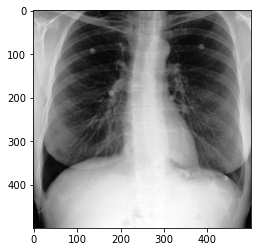

In [807]:
plt.imshow(x[i, 0, :, :].cpu(), cmap="gray")

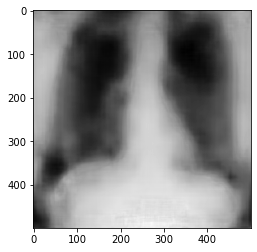

In [808]:
with torch.no_grad():
    pred = ae.fullpass(x[i, :, :, :].unsqueeze(1))[0][0, 0, :, :].detach().cpu()
plt.imshow(pred, cmap="gray")

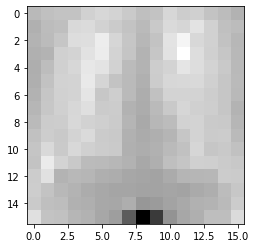

In [810]:
with torch.no_grad():
    pred = ae(x[i, :, :, :].unsqueeze(1))[0, 0, :, :].detach().cpu()
plt.imshow(pred, cmap="gray")

In [777]:
toto = torch.tensor(np.random.randn(
    100, 1, 16, 16
), dtype=torch.float32).to("cuda:0")

In [618]:
torch.save(
    ae.state_dict(),
    "./models/ae.model"
)

# Getting data projection

In [619]:
n_batch = 16
dataloader_project = DataLoader(range(len(X0_train)), shuffle=False, batch_size=n_batch, num_workers=4)

In [620]:
projections = []
device="cuda:0"

for idx in dataloader_project:
    print(f"Processing {n_batch} images")
    with torch.no_grad():
        x = dataset_collater_nocrop(X0[idx])
        x = x.to(device)
        y = ae(x)
        y = y.cpu().detach()
        projections.append(y)

Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16 images
Processing 16

In [621]:
projected_data = torch.concat(projections, axis=0).numpy()

In [622]:
import pickle

In [623]:
with open("./data/projected_data.pickle", "wb") as f:
    pickle.dump(projected_data, f)

# K Means

In [624]:
import pickle

In [625]:
with open("./data/projected_data.pickle", "rb") as f:
    projected_data = pickle.load(f)

In [626]:
projected_data = projected_data.reshape(projected_data.shape[0], -1)

In [627]:
from matplotlib import pyplot as plt

In [628]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

In [484]:
projected_test_data_lr = PCA(n_components=5).fit_transform(projected_data)

In [685]:
km = KMeans(n_clusters=5)
#dbs = DBSCAN(metric="cosine", min_samples=5, eps=5e-3)
#clusters = dbs.fit_predict(projected_test_data_lr)
clusters = km.fit_predict(projected_data)
np.bincount(clusters+abs(clusters.min()))

array([ 891, 1140, 1364, 1383,  474])

<AxesSubplot:>

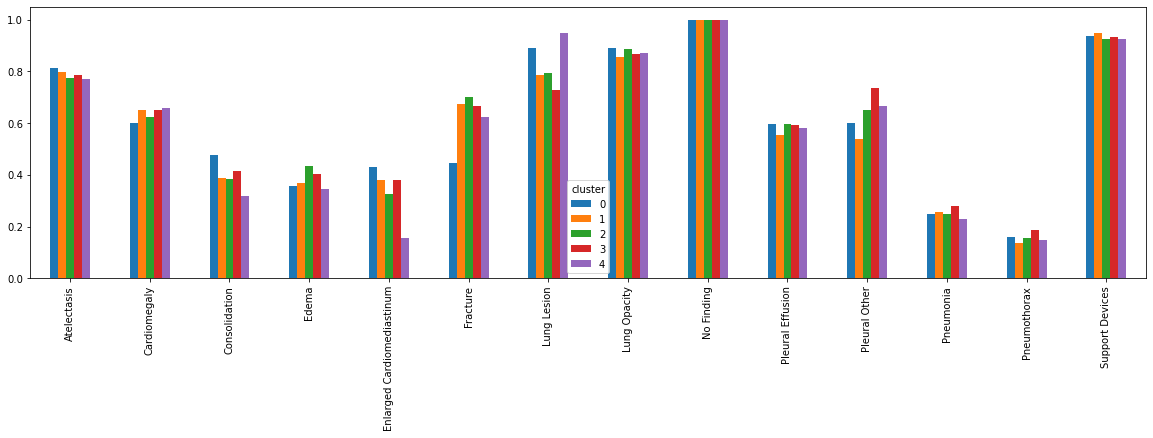

In [686]:
labels_cluster = y_train.copy()
labels_cluster["cluster"] = clusters

labels_cluster = labels_cluster[[
    "cluster",
    'Atelectasis', 'Cardiomegaly',
    'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
    'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
    'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
]]

for x in labels_cluster.columns:
    labels_cluster.loc[labels_cluster[x] < 0, x] = 0

labels_cluster.groupby("cluster").mean().T.plot.bar(figsize=(20,5))

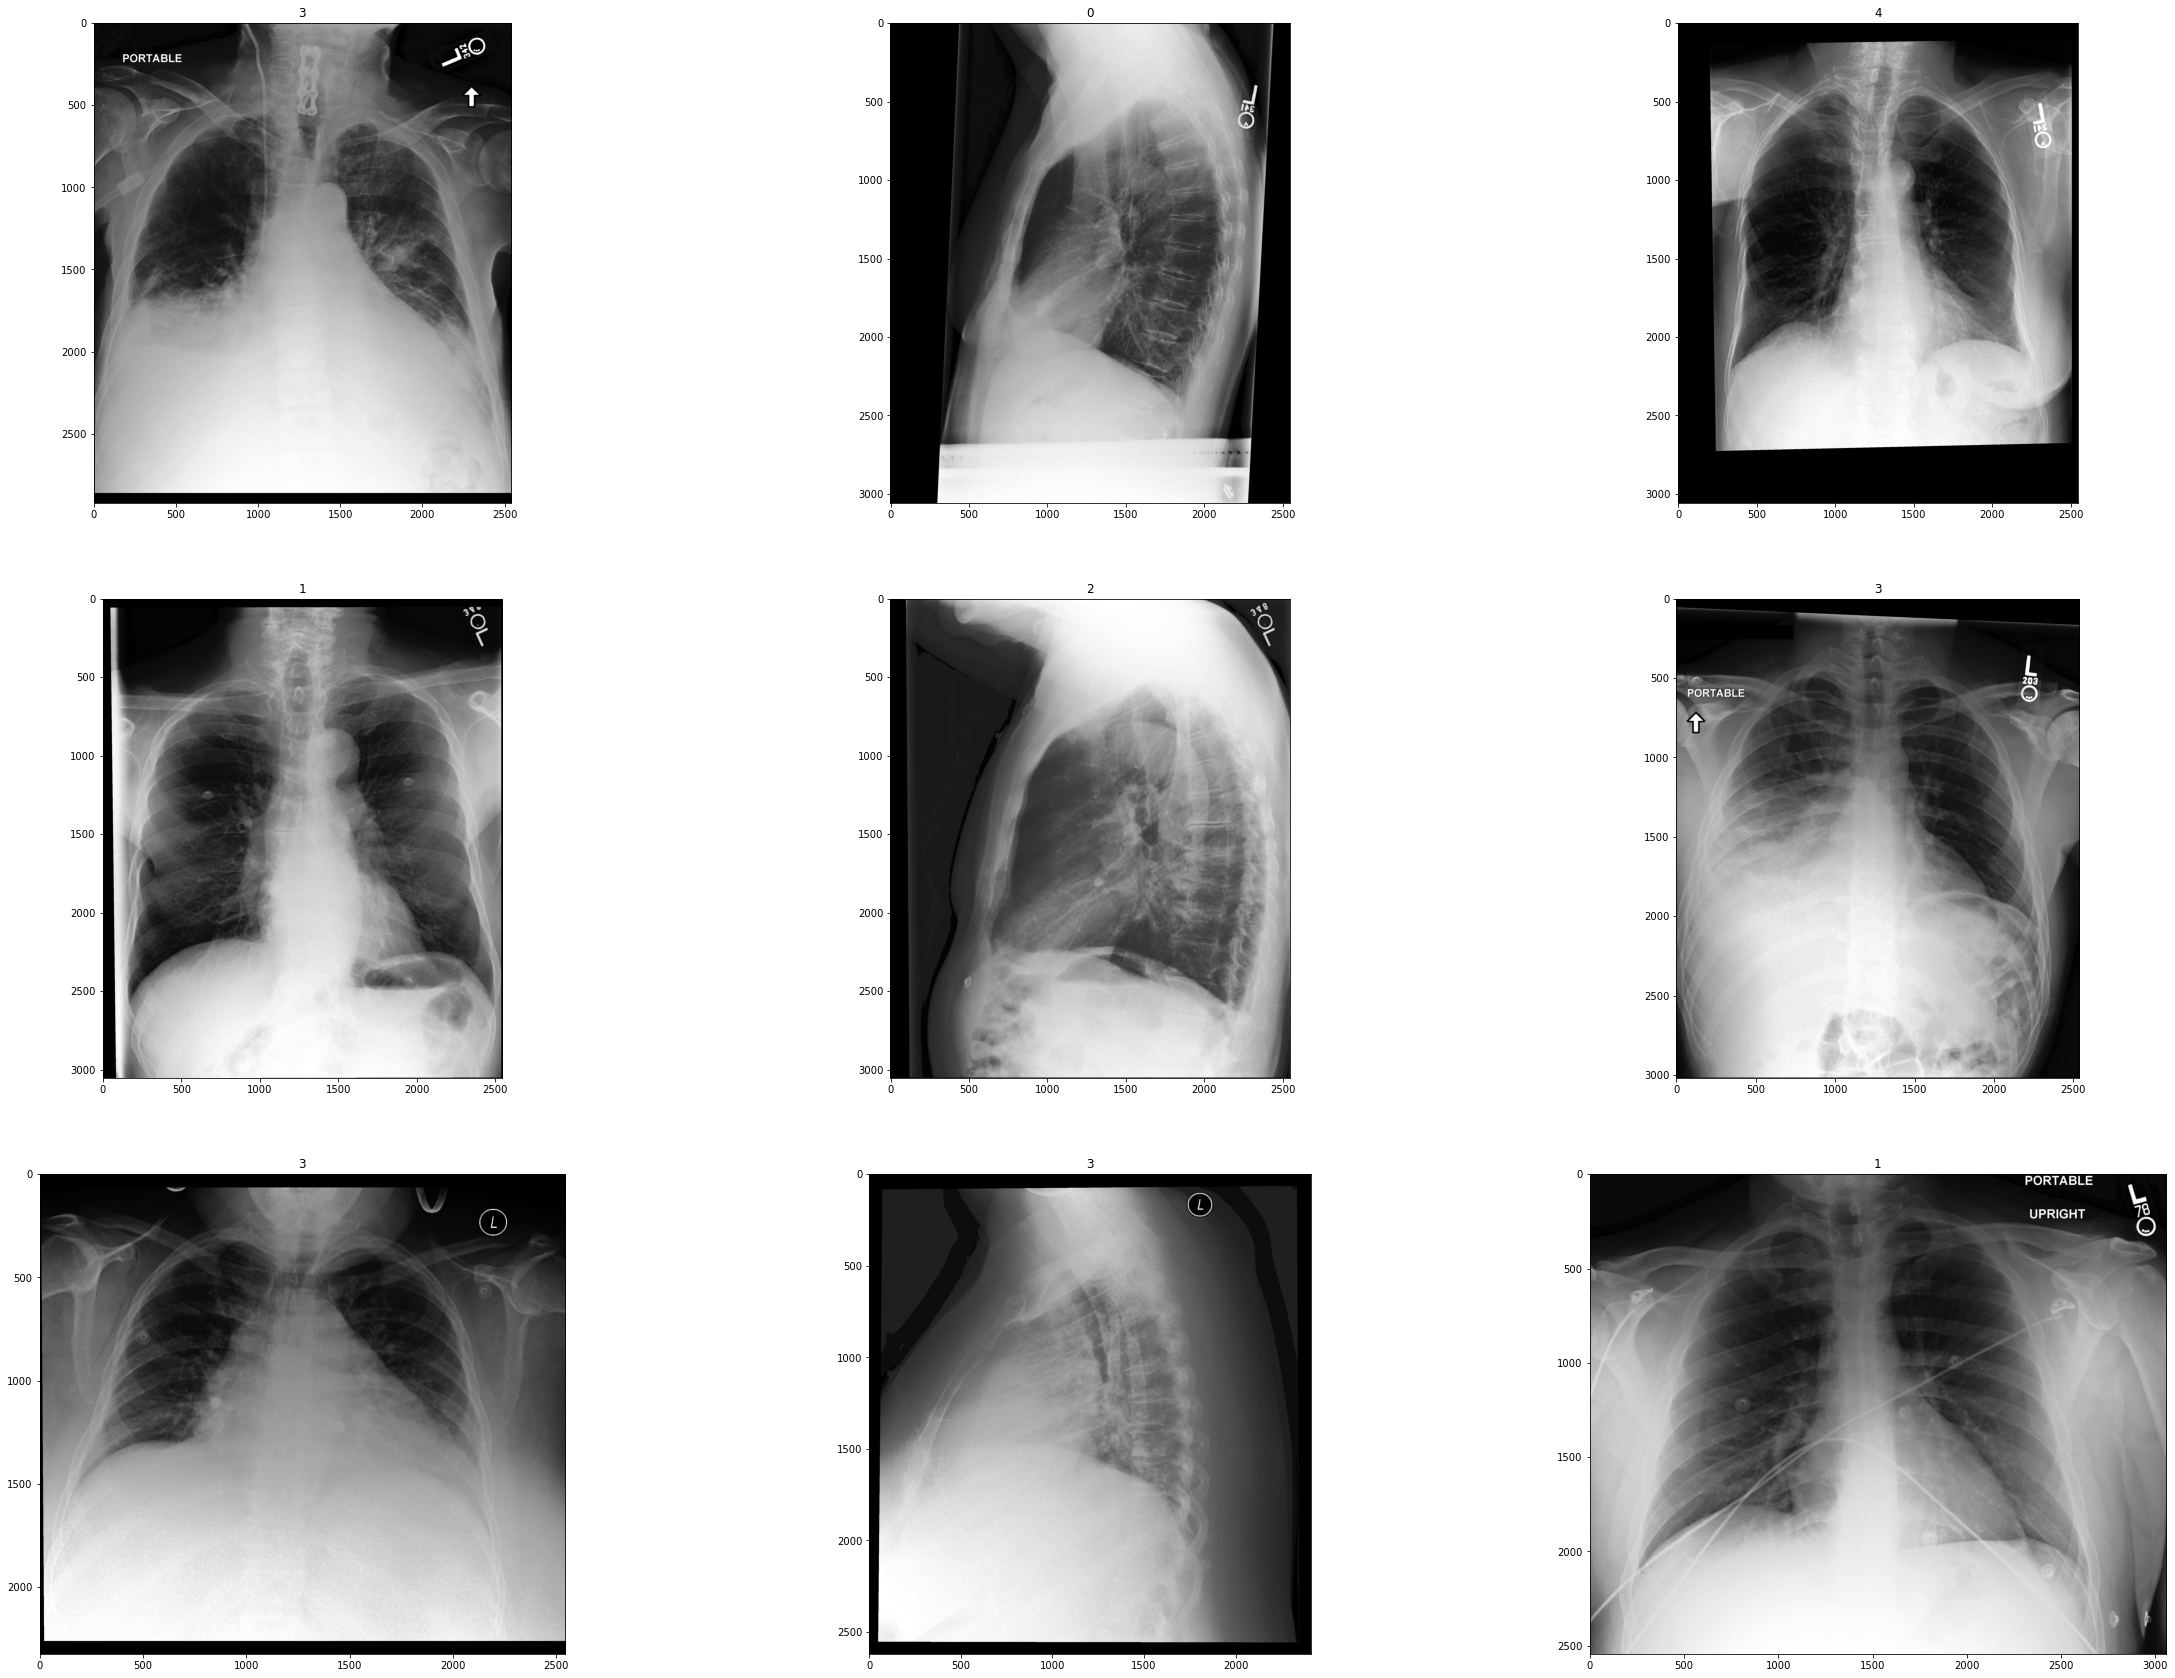

In [687]:
figs, axs = plt.subplots(3,3, figsize=(40,30))
axs = axs.flatten()

start_id = 500
end_id = start_id+9

images = X0[start_id:end_id]
for (i, j) in zip(range(len(images)), range(start_id, end_id, 1)):
    axs[i].imshow(
        images[i],
        cmap="gray"
    )
    axs[i].set_title(clusters[j])

In [498]:
from sklearn.manifold import TSNE

In [499]:
low_projection = TSNE(n_components=2, perplexity=30).fit_transform(projected_data)

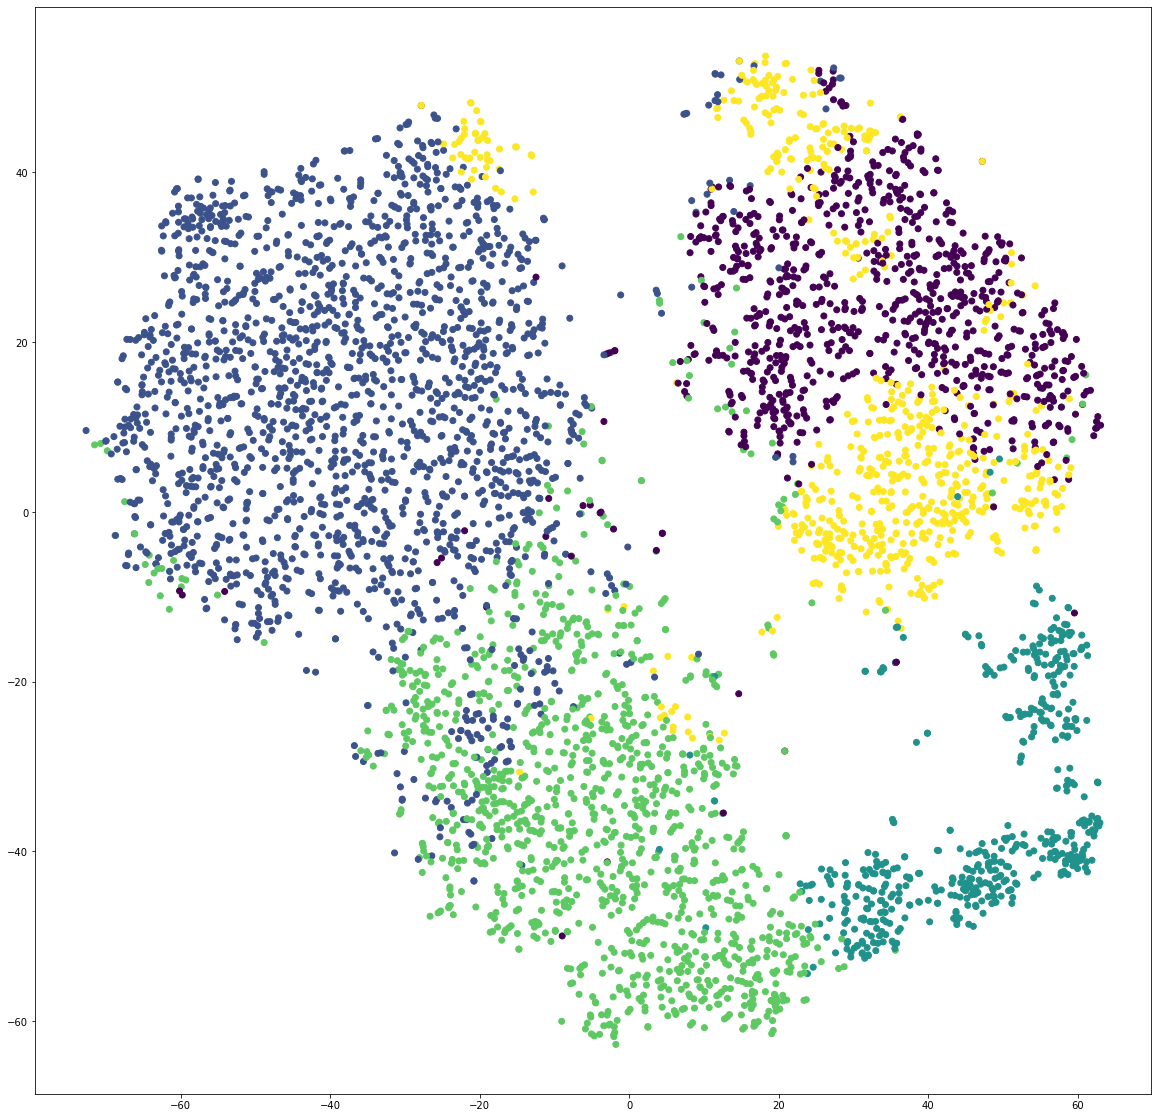

In [500]:
plt.figure(figsize=(20,20))
plt.scatter(
    low_projection[:, 0],
    low_projection[:, 1],
    c=clusters
)

## Labels

# Reading documents

In [501]:
y_train_copy = y_train.copy()
y_train_copy["cluster"] = clusters

In [502]:
import wordcloud

In [503]:
y_train_copy

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,text_label,report,report_extra,report_comparison,report_findings,report_impression,report_indication,report_reason_for_exam,report_reason_for_examination,cluster
0,10001401,58747570,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,No Finding,FINAL REPORT\...,,___,AP upright and lateral views of the chest prov...,Hilar congestion without frank edema. No conv...,___F with SOB // r/o acute process,,,1
1,10001401,58747570,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,No Finding,FINAL REPORT\...,,___,AP upright and lateral views of the chest prov...,Hilar congestion without frank edema. No conv...,___F with SOB // r/o acute process,,,0
2,10002930,55885481,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,"Atelectasis,Fracture",WET READ: ___ ___ ___ 4:34 PM\n No acute car...,Chest AP upright and lateral,None,AP upright and lateral views the chest were pr...,1. Mild left basal atelectasis. Otherwise unr...,"___F with EtOH, repeat head strikes, mid thora...",,,2
3,10003019,52117631,1.0,0.0,NaN,0.0,NaN,NaN,1.0,1.0,...,"Atelectasis,Lung Lesion,Lung Opacity,Pleural O...",FINAL REPORT\...,,Outside hospital films from ___.,The exam is compared to an outside hospital fi...,,"Fever and cough, evaluation for sarcoid.",,,4
4,10003019,52117631,1.0,0.0,NaN,0.0,NaN,NaN,1.0,1.0,...,"Atelectasis,Lung Lesion,Lung Opacity,Pleural O...",FINAL REPORT\...,,Outside hospital films from ___.,The exam is compared to an outside hospital fi...,,"Fever and cough, evaluation for sarcoid.",,,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5247,19982872,50370111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,No Finding,FINAL REPORT\...,[],___,No focal consolidation is seen there is no pl...,No acute cardiopulmonary process. No signific...,,,,1
5248,19988669,54173302,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,...,Lung Opacity,FINAL REPORT\...,,___.,,"As compared to the previous radiograph, no def...",___ year old man with injuries r/t accident. ...,,,0
5249,19988669,54173302,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,...,Lung Opacity,FINAL REPORT\...,,___.,,"As compared to the previous radiograph, no def...",___ year old man with injuries r/t accident. ...,,,1
5250,19991085,52519819,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,...,"No Finding,Support Devices",FINAL REPORT\...,,Comparison made to chest radiograph performed ...,Chest PA and lateral radiograph demonstrates u...,,"Dual-chamber pacemaker, please evaluate lead p...",,,3


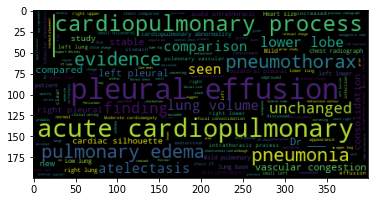

In [504]:
wc = wordcloud.WordCloud().generate(
    " ".join(y_train_copy["report_impression"].fillna("").astype("str").values.tolist())
)

plt.imshow(wc)

## By cluster

In [505]:
wc_cluster = {}

stopwords = set(wordcloud.STOPWORDS)
stopwords.add("left")
stopwords.add("right")
stopwords.add("final")
stopwords.add("report")
stopwords.add("unchanged")

for cluster in y_train_copy["cluster"].unique():
    wc = wordcloud.WordCloud(
        stopwords=stopwords,
        max_words=20, 
        relative_scaling=1
    ).generate(
        " ".join(
            y_train_copy.query(f"cluster == {cluster}")["report_impression"].fillna("").astype("str").values.tolist()
        )
    )
    wc_cluster[cluster] = wc

Text(0.5, 1.0, 'Cluster 0')

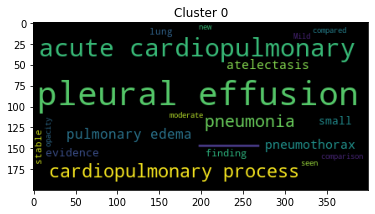

In [506]:
plt.imshow(wc_cluster[0])
plt.title("Cluster 0")

Text(0.5, 1.0, 'Cluster 1')

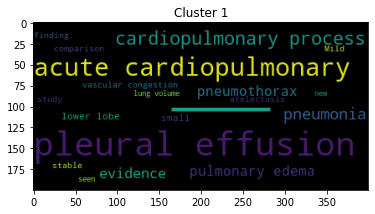

In [507]:
plt.imshow(wc_cluster[1])
plt.title("Cluster 1")

Text(0.5, 1.0, 'Cluster 2')

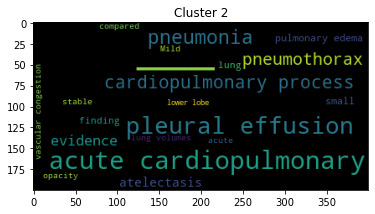

In [508]:
plt.imshow(wc_cluster[2])
plt.title("Cluster 2")

Text(0.5, 1.0, 'Cluster 3')

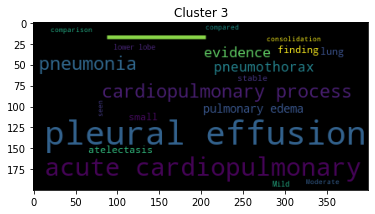

In [509]:
plt.imshow(wc_cluster[3])
plt.title("Cluster 3")

Text(0.5, 1.0, 'Cluster 4')

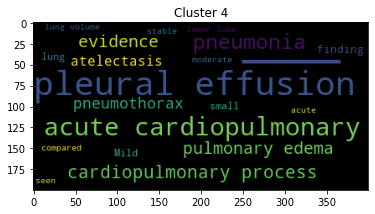

In [510]:
plt.imshow(wc_cluster[4])
plt.title("Cluster 4")

Text(0.5, 1.0, 'Cluster 5')

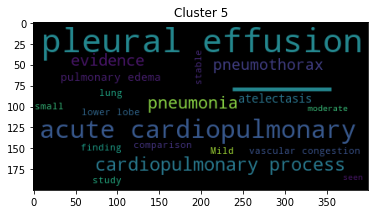

In [259]:
plt.imshow(wc_cluster[5])
plt.title("Cluster 5")

Text(0.5, 1.0, 'Cluster 6')

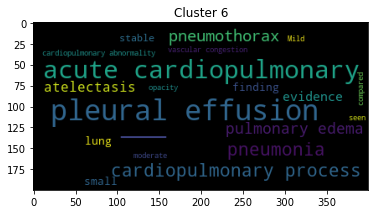

In [260]:
plt.imshow(wc_cluster[6])
plt.title("Cluster 6")

Text(0.5, 1.0, 'Cluster 7')

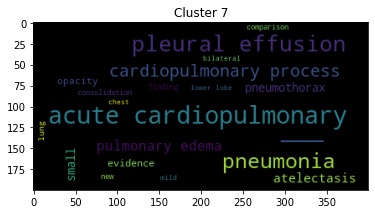

In [261]:
i = 7
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

Text(0.5, 1.0, 'Cluster 8')

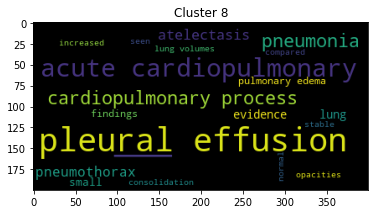

In [262]:
i = 8
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

Text(0.5, 1.0, 'Cluster 9')

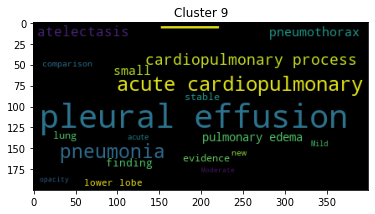

In [263]:
i = 9
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [264]:
i = 10
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

KeyError: 10

Text(0.5, 1.0, 'Cluster 11')

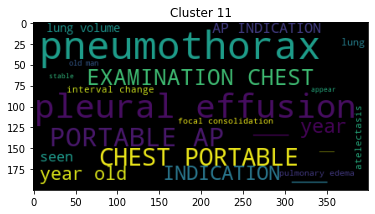

In [ ]:
i = 11
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

Text(0.5, 1.0, 'Cluster 12')

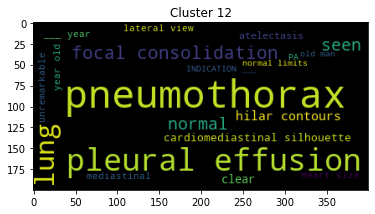

In [ ]:
i = 12
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

Text(0.5, 1.0, 'Cluster 13')

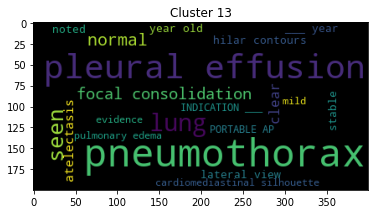

In [ ]:
i = 13
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

Text(0.5, 1.0, 'Cluster 14')

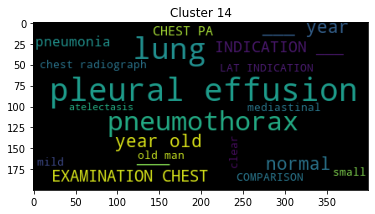

In [ ]:
i = 14
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

Text(0.5, 1.0, 'Cluster 15')

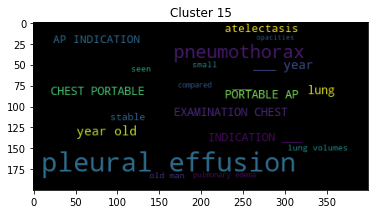

In [ ]:
i = 15

plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

Text(0.5, 1.0, 'Cluster 16')

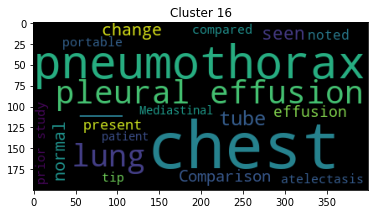

In [ ]:
i = 16
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

Text(0.5, 1.0, 'Cluster 17')

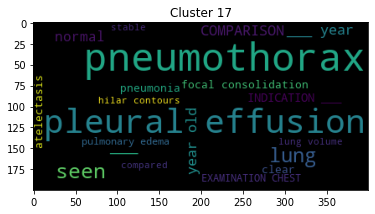

In [ ]:
i = 17
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

Text(0.5, 1.0, 'Cluster 18')

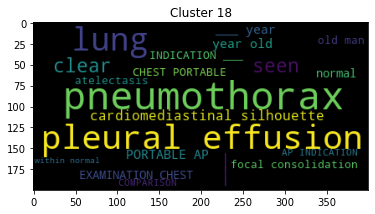

In [ ]:
i = 18
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

Text(0.5, 1.0, 'Cluster 19')

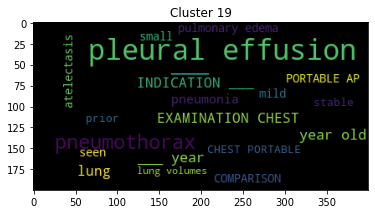

In [ ]:
i = 19
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")